# 基于pytorch的 Predicting Atomization Energy 实现 
by Wowrj \
contact me: 1518725978@qq.com


###  $\color{red}{Step~1.}$ 导入所需要的库

In [39]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [40]:
rand_state = 42
np.random.seed(rand_state)

In [94]:
#使用scipy.io导入matlab形式的数据
# 数据下载自 http://quantum-machine.org/
qm7 = scipy.io.loadmat("./qm7/qm7.mat")
print(qm7["X"].shape)
print(qm7["T"].shape)

(7165, 23, 23)
(1, 7165)


##### 下一步将数据集制作成输入，对特征进行feature sacling,这一步的目的是为了加快收敛，减少采用梯度下降算法迭代的次数，依据自己的数据集特点选择不同的sacling factor

In [95]:
#对于库伦矩阵输入，这个值我们设置为370；能量我们设置为2000，比较进行缩放和不进行缩放值的特点
CM_scaled=qm7["X"].reshape((7165,1,23,23))/370 #coulomb Matriices with sacled
y_scaled=np.transpose(qm7["T"]).reshape((7165,))/2000# atomization energy with sacled (unit:kcal/mol)

###  $\color{red}{Step~2.1.}$  使用二维卷积的方法训练这个模型

In [96]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split #拆分输入成为训练集，验证集
#分成训练集和验证集 转为torch里的tensor 结构
X_cm_train,X_cm_test,y_train,y_test=train_test_split(CM_scaled,y_scaled,test_size=0.2,random_state=rand_state)
y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]
X_cm_train =torch.as_tensor(torch.from_numpy(X_cm_train), dtype=torch.float32)
y_train = torch.as_tensor(torch.from_numpy(y_train), dtype=torch.float32)
X_cm_test =torch.as_tensor(torch.from_numpy(X_cm_test), dtype=torch.float32)
y_test = torch.as_tensor(torch.from_numpy(y_test), dtype=torch.float32)
#构建简单网络
net = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=7, padding='same'), nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=5), nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(15488, 1))

In [97]:
import torch.utils.data as Data	
# 指定损失函数
criterion = nn.L1Loss()	# mae
# 指定优化器，可以是其他
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate,betas=(0.9,0.999),eps=1e-08,weight_decay=0.0)
batch_size = 64	# 或其他，该参数属于超参，对于如何选择超参，你可以参考下我的上一篇博客
n_epochs = 100	# 可以设置大一些，毕竟你是希望通过 early stopping 来结束模型训练

# 训练模型，直到 epoch == n_epochs 
trlo=[]
valo=[]
start=time.time()
for epoch in range(1, n_epochs + 1):
	# 建立训练数据的 DataLoader
	training_dataset = Data.TensorDataset(X_cm_train, y_train)
	# 把dataset放到DataLoader中
	data_loader = Data.DataLoader(dataset=training_dataset,batch_size=32)
	#---------------------------------------------------
	net.train()	# 设置模型为训练模式
    # 按小批量训练
	lo = []
	for batch, (data, target) in enumerate(data_loader):
		output = net(data)
		loss = criterion(output, target)	# 计算损失
		lo.append(loss.item())
		optimizer.zero_grad()	# 清除所有参数的梯度
		loss.backward()	# 计算损失对于各个参数的梯度
		optimizer.step() # 执行单步优化操作：更新参数
	trlo.append(min(lo))

	# 计算在测试集上的loss
	testing_dataset = Data.TensorDataset(X_cm_test, y_test)
	# 把dataset放到DataLoader中
	data_loadert = Data.DataLoader(dataset=testing_dataset)

	with torch.no_grad():
		for data in data_loadert:
			data,target = data
			valid_output = net(data)
			valid_loss = criterion(valid_output, target)
	valo.append(valid_loss.item())
	print('第{}轮'.format(epoch),'mae_train',loss.item(),'mae_test',valid_loss.item())
torch.save(net.state_dict(), 'model1.pt')
end=time.time()

第1轮 mae_train 0.03575770556926727 mae_test 0.21845275163650513
第2轮 mae_train 0.05094076693058014 mae_test 0.16249680519104004
第3轮 mae_train 0.032431453466415405 mae_test 0.11637669801712036
第4轮 mae_train 0.033707037568092346 mae_test 0.1399051547050476
第5轮 mae_train 0.012996122241020203 mae_test 0.0682629942893982
第6轮 mae_train 0.0067720115184783936 mae_test 0.013102352619171143
第7轮 mae_train 0.009708017110824585 mae_test 0.02086019515991211
第8轮 mae_train 0.007303446531295776 mae_test 0.003355085849761963
第9轮 mae_train 0.009467005729675293 mae_test 0.0060923099517822266
第10轮 mae_train 0.01197265088558197 mae_test 0.015020430088043213
第11轮 mae_train 0.006646960973739624 mae_test 0.010558128356933594
第12轮 mae_train 0.006899893283843994 mae_test 0.005327820777893066
第13轮 mae_train 0.0044823139905929565 mae_test 0.015761077404022217
第14轮 mae_train 0.005522415041923523 mae_test 0.01518028974533081
第15轮 mae_train 0.005569145083427429 mae_test 0.0029796361923217773
第16轮 mae_train 0.0068611353

###  $\color{red}{Step~3.1}$  查看结果

In [98]:
##算MAE和损失需要乘上sacling fator 2000
print('Execution time: ', end-start)
print("Epochs: ", len(trlo))
print('Train loss: ', 2000*min(trlo))
print('Test loss: ', 2000*min(valo))
print("MAE",2000*min(trlo))

Execution time:  4318.642347812653
Epochs:  100
Train loss:  2.4945735931396484
Test loss:  0.2989768981933594
MAE 2.4945735931396484


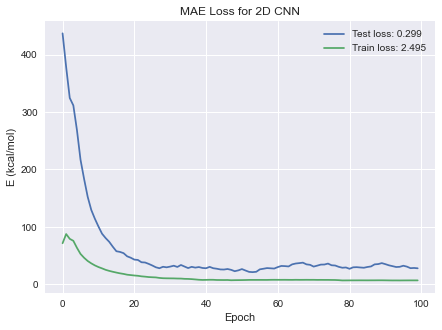

In [99]:
plt.figure(figsize=(7,5))
plt.style.use('seaborn')
train_label = "Train loss: {}".format(np.round(np.min(np.array(trlo))*2000, 3))
test_label = "Test loss: {}".format(np.round(np.min(np.array(valo))*2000, 3))
(pd.Series(valo).ewm(alpha=0.1).mean()*2000).plot(label=test_label)   #作图曲线平滑一点
(pd.Series(trlo).ewm(alpha=.1).mean()*2000).plot(label=train_label)
plt.legend()
plt.title('MAE Loss for 2D CNN')
plt.xlabel('Epoch')
plt.ylabel('E (kcal/mol)')
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


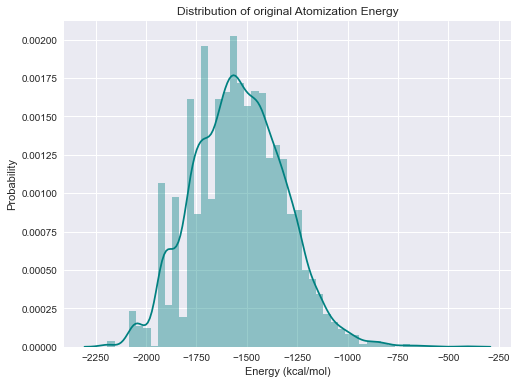

In [100]:
#元数据的能量分布
plt.figure(figsize=(8,6))
sns.distplot(y_scaled*2000,color="teal")
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of original Atomization Energy')
plt.show()

In [101]:
#利用数据中的库伦矩阵预测能量
#net.load_state_dict(torch.load('checkpoint.pt'))	
pre=[]
for i in range(len(CM_scaled)):
    input_x=np.expand_dims(CM_scaled[i],axis=0)
    value=net(torch.as_tensor(torch.from_numpy(input_x)))
    pre.append(value.item())
prevalue=np.squeeze(np.array(pre)*2000)

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


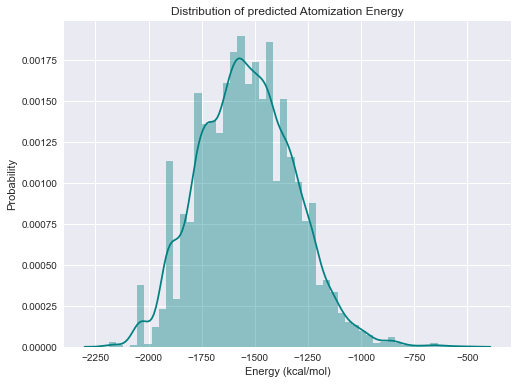

In [102]:
#模型预测的后能量的分布
plt.figure(figsize=(8,6))
sns.distplot(prevalue,color="teal")
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of predicted Atomization Energy')
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


C:\Users\user\AppData\Local\Temp\ipykernel_32728\4138561557.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([-2400,-400],[-2400,-400],"k-",linestyle="--")


Text(0, 0.5, 'predicted atomization energy(kcal/mol)')

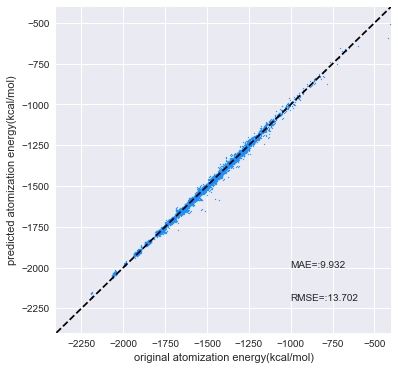

In [103]:
from scipy.interpolate import interpn
MAE="MAE=:{}".format(np.round(np.mean(np.abs(y_scaled-np.squeeze(np.array(pre))))*2000,3))
RMSE="RMSE=:{}".format(np.round(np.sqrt(np.mean(np.square(y_scaled-np.squeeze(np.array(pre)))))*2000,3))
data,x_e,y_e=np.histogram2d(y_scaled.flatten(),np.array(pre).flatten(),bins=10000)
font={"family":"normal","size":"10"}
print(data)
plt.figure(figsize=(6,6))
plt.scatter(y_scaled*2000,np.squeeze(np.array(pre))*2000,s=1,color="dodgerblue")
plt.xlim(-2400,-400)
plt.ylim(-2400,-400)
plt.text(-1000,-2000,MAE)
plt.text(-1000,-2200,RMSE)
plt.plot([-2400,-400],[-2400,-400],"k-",linestyle="--")
plt.xlabel("original atomization energy(kcal/mol)")
plt.ylabel("predicted atomization energy(kcal/mol)")
#print("RMSE:",np.sqrt(np.mean(np.square(y_scaled*2000-np.squeeze(np.array(pre))*2000))))
#print(y_scaled)
#print(np.squeeze(np.array(pre)))

##### 导入一个模型试试(在前面已经保存模型了)

In [104]:
net.load_state_dict(torch.load('model1.pt'))	
X = torch.rand(size=(1, 1, 23, 23), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 32, 23, 23])
ReLU output shape: 	 torch.Size([1, 32, 23, 23])
Conv2d output shape: 	 torch.Size([1, 64, 19, 19])
ReLU output shape: 	 torch.Size([1, 64, 19, 19])
Conv2d output shape: 	 torch.Size([1, 64, 17, 17])
ReLU output shape: 	 torch.Size([1, 64, 17, 17])
Conv2d output shape: 	 torch.Size([1, 64, 15, 15])
ReLU output shape: 	 torch.Size([1, 64, 15, 15])
Conv2d output shape: 	 torch.Size([1, 128, 13, 13])
ReLU output shape: 	 torch.Size([1, 128, 13, 13])
Conv2d output shape: 	 torch.Size([1, 128, 11, 11])
ReLU output shape: 	 torch.Size([1, 128, 11, 11])
Flatten output shape: 	 torch.Size([1, 15488])
Linear output shape: 	 torch.Size([1, 1])


In [105]:
pre1=[]
for i in range(len(CM_scaled)):
    input_x=np.expand_dims(CM_scaled[i],axis=0)
    value=net(torch.as_tensor(torch.from_numpy(input_x)))
    pre1.append(value.item())
pre1value=np.squeeze(np.array(pre)*2000)

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


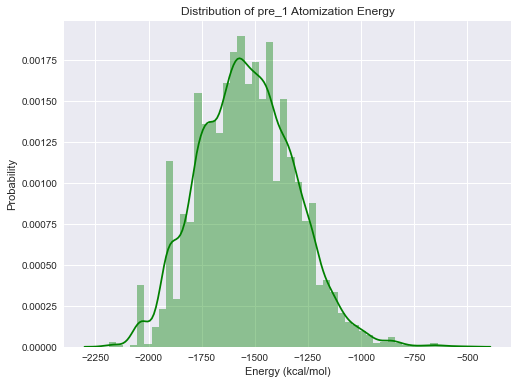

In [106]:
plt.figure(figsize=(8,6))
sns.distplot(pre1value,color="green")
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of pre_1 Atomization Energy')
plt.show()

###  $\color{red}{Step~2.2.}$ 前馈神经网络(以特征值为输入)
库伦矩阵是23x23的矩阵，以特征值为1*23的矩阵，可以使用简单的一维卷积，也可以用前馈神经网络实现。

In [88]:
#特征值与特征向量,调用numpy实现特征值的计算
print(np.squeeze(CM_scaled[1]).shape)
eigenvalue,eigenvector=np.linalg.eig(np.squeeze(CM_scaled[1]))
print(eigenvalue.shape)

(23, 23)
(23,)


In [89]:
#构建特征值作为描述符
eigenraw=[]
for i in range(len(CM_scaled)):
    eigenvalue,egienvector=np.linalg.eig(np.squeeze(CM_scaled[i]))
    eigenraw.append(eigenvalue)
eigeninput=np.array(eigenraw)
print(eigeninput.shape)

(7165, 23)


In [90]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split #拆分输入成为训练集，验证集
#拆分数据集，一部分作为训练集，一部分作为验证数据
eigen_train,eigen_val,eigen_train_y,eigen_val_y=train_test_split(eigeninput,y_scaled,test_size=0.2,random_state=rand_state)
eigen_train_y = eigen_train_y[:,np.newaxis]
eigen_val_y = eigen_val_y[:,np.newaxis]
eigen_train =torch.as_tensor(torch.from_numpy(eigen_train), dtype=torch.float32)
eigen_train_y = torch.as_tensor(torch.from_numpy(eigen_train_y), dtype=torch.float32)
eigen_val =torch.as_tensor(torch.from_numpy(eigen_val), dtype=torch.float32)
eigen_val_y = torch.as_tensor(torch.from_numpy(eigen_val_y), dtype=torch.float32)

model_eigen = nn.Sequential(
    nn.Linear(23, 20), nn.Tanh(),
    nn.Linear(20, 20,), nn.Tanh(),
    nn.Linear(20, 20,), nn.Tanh(),
    nn.Linear(20, 1,),
)
X = torch.rand(size=(1,23), dtype=torch.float32)
for layer in model_eigen:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Linear output shape: 	 torch.Size([1, 20])
Tanh output shape: 	 torch.Size([1, 20])
Linear output shape: 	 torch.Size([1, 20])
Tanh output shape: 	 torch.Size([1, 20])
Linear output shape: 	 torch.Size([1, 20])
Tanh output shape: 	 torch.Size([1, 20])
Linear output shape: 	 torch.Size([1, 1])


In [91]:
import torch.utils.data as Data	
# 指定损失函数，可以是其他损失函数，根据训练要求决定
criterion = nn.L1Loss()	# mae
# 指定优化器，可以是其他
learning_rate = 0.001
optimizer = torch.optim.Adam(model_eigen.parameters(),lr=learning_rate,betas=(0.9,0.999),eps=1e-08,weight_decay=0.0)
# 初始化 early_stopping 对象
batch_size = 100	# 或其他，该参数属于超参，对于如何选择超参，你可以参考下我的上一篇博客
n_epochs = 150	
#----------------------------------------------------------------
# 训练模型，直到 epoch == n_epochs 或者触发 early_stopping 结束训练
trlo=[]
valo=[]
start=time.time()
for epoch in range(1, n_epochs + 1):
	# 建立训练数据的 DataLoader
	training_dataset = Data.TensorDataset(eigen_train, eigen_train_y)
	# 把dataset放到DataLoader中
	data_loader = Data.DataLoader(dataset=training_dataset,batch_size=32)

	#---------------------------------------------------
	model_eigen.train()	# 设置模型为训练模式
    # 按小批量训练
	lo = []
	for batch, (data, target) in enumerate(data_loader):
		output = model_eigen(data)
		loss = criterion(output, target)	# 计算损失
		lo.append(loss.item())
		optimizer.zero_grad()	# 清楚所有参数的梯度
		loss.backward()	# 计算损失对于各个参数的梯度
		optimizer.step() # 执行单步优化操作：更新参数
	trlo.append(min(lo))
	testing_dataset = Data.TensorDataset(eigen_val, eigen_val_y)
	# 把dataset放到DataLoader中
	data_loadert = Data.DataLoader(dataset=testing_dataset)
	#测试
	with torch.no_grad():
		for data in data_loadert:
			data,target = data
			valid_output = model_eigen(data)
			valid_loss = criterion(valid_output, target)
	valo.append(valid_loss.item())
	print('第{}轮'.format(epoch),'mae_train',loss.item(),'mae_test',valid_loss.item())
torch.save(model_eigen.state_dict(), 'model2.pt')
end=time.time()

第1轮 mae_train 0.04726414382457733 mae_test 0.1689956784248352
第2轮 mae_train 0.03359617292881012 mae_test 0.14212632179260254
第3轮 mae_train 0.03109532594680786 mae_test 0.06546539068222046
第4轮 mae_train 0.039175018668174744 mae_test 0.054240405559539795
第5轮 mae_train 0.037120312452316284 mae_test 0.09346550703048706
第6轮 mae_train 0.037875354290008545 mae_test 0.10252624750137329
第7轮 mae_train 0.03748880326747894 mae_test 0.10721009969711304
第8轮 mae_train 0.03897362947463989 mae_test 0.11586588621139526
第9轮 mae_train 0.03636297583580017 mae_test 0.11960965394973755
第10轮 mae_train 0.04074248671531677 mae_test 0.1207306981086731
第11轮 mae_train 0.030267328023910522 mae_test 0.13044744729995728
第12轮 mae_train 0.028134673833847046 mae_test 0.1288425326347351
第13轮 mae_train 0.02789786458015442 mae_test 0.1160096526145935
第14轮 mae_train 0.03517082333564758 mae_test 0.08863645792007446
第15轮 mae_train 0.025883808732032776 mae_test 0.09324342012405396
第16轮 mae_train 0.01949116587638855 mae_test 0.

###  $\color{red}{Step~3.2}$  查看结果

In [92]:
##算MAE和损失需要乘上sacling fator 2000
print('Execution time: ', end-start)
print("Epochs: ", len(trlo))
print('Train loss: ', 2000*min(trlo))
print('Test loss: ', 2000*min(valo))
print("MAE",2000*min(trlo))

Execution time:  220.1541759967804
Epochs:  150
Train loss:  16.473975032567978
Test loss:  0.2053976058959961
MAE 16.473975032567978


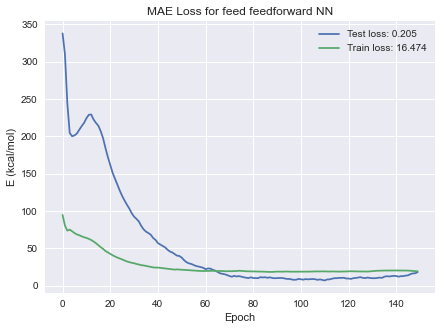

In [93]:
plt.figure(figsize=(7,5))
train_label = "Train loss: {}".format(np.round(np.min(np.array(trlo))*2000, 3))
test_label = "Test loss: {}".format(np.round(np.min(np.array(valo))*2000, 3))
(pd.Series(valo).ewm(alpha=0.1).mean()*2000).plot(label=test_label)#作图曲线平滑一点
(pd.Series(trlo).ewm(alpha=.1).mean()*2000).plot(label=train_label)
plt.legend()
plt.title('MAE Loss for feed feedforward NN')
plt.xlabel('Epoch')
plt.ylabel('E (kcal/mol)')
plt.show()

可见使用特征值的训练很差，loss中MAE

In [61]:
pre2=[]
for i in range(len(eigeninput)):
    input_x=np.expand_dims(eigeninput[i],axis=0)
    value=model_eigen(torch.as_tensor(torch.from_numpy(input_x)))
    pre2.append(value.item())
pre2value=np.squeeze(np.array(pre2)*2000)

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


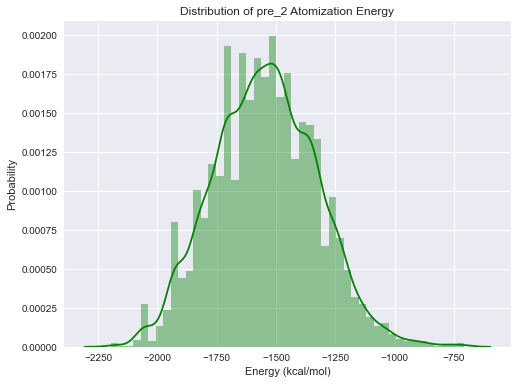

In [62]:
plt.figure(figsize=(8,6))
sns.distplot(pre2value,color="green")
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of pre_2 Atomization Energy')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_32728\549312331.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([-2400,-400],[-2400,-400],"k-",linestyle="--")


Text(0, 0.5, 'predicted atomization energy(kcal/mol)')

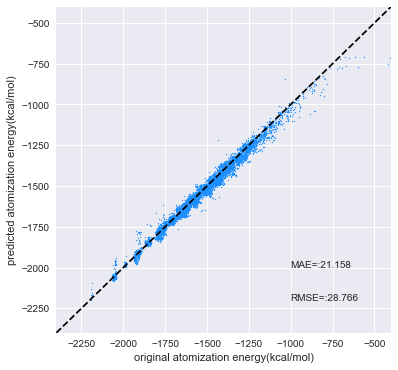

In [63]:
from scipy.interpolate import interpn
import matplotlib
MAE="MAE=:{}".format(np.round(np.mean(np.abs(y_scaled-np.squeeze(np.array(pre2))))*2000,3))
RMSE="RMSE=:{}".format(np.round(np.sqrt(np.mean(np.square(y_scaled-np.squeeze(np.array(pre2)))))*2000,3))
#data,x_e,y_e=np.histogram2d(y_scaled.flatten(),np.array(pre2).flatten(),bins=10000)
font={"family":"normal","size":"10"}
#print(data)
plt.figure(figsize=(6,6))
plt.scatter(y_scaled*2000,np.squeeze(np.array(pre2))*2000,s=1,color="dodgerblue")
plt.xlim(-2400,-400)
plt.ylim(-2400,-400)
plt.text(-1000,-2000,MAE)
plt.text(-1000,-2200,RMSE)
plt.plot([-2400,-400],[-2400,-400],"k-",linestyle="--")
plt.xlabel("original atomization energy(kcal/mol)")
plt.ylabel("predicted atomization energy(kcal/mol)")
#print("RMSE:",np.sqrt(np.mean(np.square(y_scaled*2000-np.squeeze(np.array(pre))*2000))))
#print(y_scaled)
#print(np.squeeze(np.array(pre)))

###  $\color{red}{Step~2.3.}$ 前馈神经网络(以库伦矩阵为输入) 
在前馈中还可以用库伦矩阵作为输入

In [78]:
#需要将23*23矩阵做成一个输入529的输入
print(np.squeeze(CM_scaled[1]).shape)
print(np.squeeze(CM_scaled[1].reshape(529,1)).shape)

(23, 23)
(529,)


In [79]:
#构建一维矩阵作为输入
onedimraw=[]
for i in range(len(CM_scaled)):
    onedim=np.squeeze(CM_scaled[i]).reshape(529)
    onedimraw.append(onedim)
onediminput=np.array(onedimraw)
print(onediminput.shape)

(7165, 529)


In [80]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split #拆分输入成为训练集，验证集
#分成训练集和验证集
onedim_train,onedim_val,onedim_train_y,onedim_val_y=train_test_split(onediminput,y_scaled,test_size=0.2,random_state=rand_state)
onedim_train_y = onedim_train_y[:,np.newaxis]
onedim_val_y = onedim_val_y[:,np.newaxis]
onedim_train =torch.as_tensor(torch.from_numpy(onedim_train), dtype=torch.float32)
onedim_train_y = torch.as_tensor(torch.from_numpy(onedim_train_y), dtype=torch.float32)
onedim_val =torch.as_tensor(torch.from_numpy(onedim_val), dtype=torch.float32)
onedim_val_y = torch.as_tensor(torch.from_numpy(onedim_val_y), dtype=torch.float32)

model_onedim = nn.Sequential(
    nn.Linear(529, 20), nn.Tanh(),
    nn.Linear(20, 20,), nn.Tanh(),
    nn.Linear(20, 20,), nn.Tanh(),
    nn.Linear(20, 1,),
)
X = torch.rand(size=(1,529), dtype=torch.float32)
for layer in model_onedim:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Linear output shape: 	 torch.Size([1, 20])
Tanh output shape: 	 torch.Size([1, 20])
Linear output shape: 	 torch.Size([1, 20])
Tanh output shape: 	 torch.Size([1, 20])
Linear output shape: 	 torch.Size([1, 20])
Tanh output shape: 	 torch.Size([1, 20])
Linear output shape: 	 torch.Size([1, 1])


In [82]:
import torch.utils.data as Data	
# 指定损失函数
criterion = nn.L1Loss()	# mae
# 指定优化器，可以是其他
learning_rate = 0.001
optimizer = torch.optim.Adam(model_onedim.parameters(),lr=learning_rate,betas=(0.9,0.999),eps=1e-08,weight_decay=0.0)
# 初始化 early_stopping 对象
batch_size = 100	# 或其他，该参数属于超参，对于如何选择超参，你可以参考下我的上一篇博客
n_epochs = 400	# 可以设置大一些，毕竟你是希望通过 early stopping 来结束模型训练

#----------------------------------------------------------------
# 训练模型，直到 epoch == n_epochs 
trlo=[]
valo=[]
start=time.time()
for epoch in range(1, n_epochs + 1):
	# 建立训练数据的 DataLoader
	training_dataset = Data.TensorDataset(onedim_train, onedim_train_y)
	# 把dataset放到DataLoader中
	data_loader = Data.DataLoader(dataset=training_dataset,batch_size=32)

	#---------------------------------------------------
	
	model_onedim.train()	# 设置模型为训练模式
    # 按小批量训练
	lo = []
	for batch, (data, target) in enumerate(data_loader):
		output = model_onedim(data)
		loss = criterion(output, target)	# 计算损失
		lo.append(loss.item())

		optimizer.zero_grad()	# 清楚所有参数的梯度
		loss.backward()	# 计算损失对于各个参数的梯度
		optimizer.step() # 执行单步优化操作：更新参数
	trlo.append(min(lo))
	testing_dataset = Data.TensorDataset(onedim_val, onedim_val_y)
	# 把dataset放到DataLoader中
	data_loadert = Data.DataLoader(dataset=testing_dataset)

	with torch.no_grad():
		for data in data_loadert:
			data,target = data
			valid_output = model_onedim(data)
			valid_loss = criterion(valid_output, target)
	valo.append(valid_loss.item())
	print(epoch,'mae_train',loss.item(),'mae_test',valid_loss.item())
torch.save(model_onedim.state_dict(), 'model3.pt')

1 mae_train 0.00467333197593689 mae_test 0.061772286891937256
2 mae_train 0.005338951945304871 mae_test 0.055045902729034424
3 mae_train 0.005152121186256409 mae_test 0.051118433475494385
4 mae_train 0.005395516753196716 mae_test 0.05420023202896118
5 mae_train 0.0053071528673172 mae_test 0.05322378873825073
6 mae_train 0.008409485220909119 mae_test 0.051096558570861816
7 mae_train 0.007985919713973999 mae_test 0.05050933361053467
8 mae_train 0.005869626998901367 mae_test 0.048165202140808105
9 mae_train 0.005478531122207642 mae_test 0.05443382263183594
10 mae_train 0.0054501742124557495 mae_test 0.05185931921005249
11 mae_train 0.007414862513542175 mae_test 0.04864078760147095
12 mae_train 0.007179170846939087 mae_test 0.0477563738822937
13 mae_train 0.00638638436794281 mae_test 0.048378825187683105
14 mae_train 0.00769554078578949 mae_test 0.045708417892456055
15 mae_train 0.00795447826385498 mae_test 0.049736976623535156
16 mae_train 0.00786060094833374 mae_test 0.046702802181243896

###  $\color{red}{Step~3.3}$  查看结果

In [83]:
##算MAE和损失需要乘上sacling fator 2000
print('Execution time: ', end-start)
print("Epochs: ", len(trlo))
print('Train loss: ', 2000*min(trlo))
print('Test loss: ', 2000*min(valo))
print("MAE",2000*min(trlo))

Execution time:  -446.43325090408325
Epochs:  400
Train loss:  6.339758634567261
Test loss:  0.8683204650878906
MAE 6.339758634567261


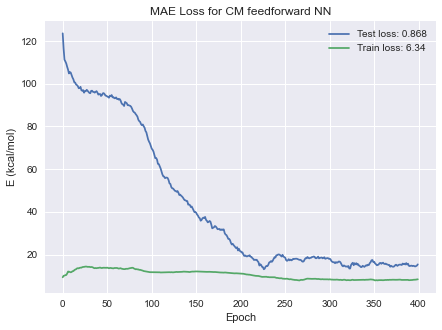

In [84]:
plt.figure(figsize=(7,5))
train_label = "Train loss: {}".format(np.round(np.min(np.array(trlo))*2000, 3))
test_label = "Test loss: {}".format(np.round(np.min(np.array(valo))*2000, 3))
(pd.Series(valo).ewm(alpha=0.1).mean()*2000).plot(label=test_label)#作图曲线平滑一点
(pd.Series(trlo).ewm(alpha=.1).mean()*2000).plot(label=train_label)
plt.legend()
plt.title('MAE Loss for CM feedforward NN')
plt.xlabel('Epoch')
plt.ylabel('E (kcal/mol)')
plt.show()

In [85]:
pre3=[]
for i in range(len(y_scaled)):
    input_x=np.expand_dims(onediminput[i],axis=0)
    value=model_onedim(torch.as_tensor(torch.from_numpy(input_x)))
    pre3.append(float(value))
pre3value=np.squeeze(np.array(pre3))*2000

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


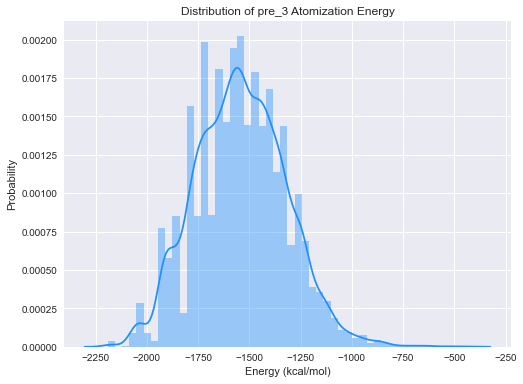

In [86]:
plt.figure(figsize=(8,6))
sns.distplot(pre3value,color="dodgerblue")
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of pre_3 Atomization Energy')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_32728\123101591.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([-2400,-400],[-2400,-400],"k-",linestyle="--")


Text(0, 0.5, 'predicted atomization energy(kcal/mol)')

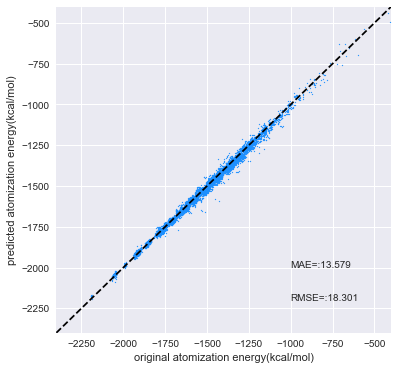

In [87]:
#from scipy.interpolate import interpn
#import matplotlib
MAE="MAE=:{}".format(np.round(np.mean(np.abs(y_scaled-np.squeeze(np.array(pre3))))*2000,3))
RMSE="RMSE=:{}".format(np.round(np.sqrt(np.mean(np.square(y_scaled-np.squeeze(np.array(pre3)))))*2000,3))
#data,x_e,y_e=np.histogram2d(y_scaled.flatten(),np.array(pre2).flatten(),bins=10000)
font={"family":"normal","size":"10"}
#print(data)
plt.figure(figsize=(6,6))
plt.scatter(y_scaled*2000,np.squeeze(np.array(pre3))*2000,s=1,color="dodgerblue")
plt.xlim(-2400,-400)
plt.ylim(-2400,-400)
plt.text(-1000,-2000,MAE)
plt.text(-1000,-2200,RMSE)
plt.plot([-2400,-400],[-2400,-400],"k-",linestyle="--")
plt.xlabel("original atomization energy(kcal/mol)")
plt.ylabel("predicted atomization energy(kcal/mol)")
#print("RMSE:",np.sqrt(np.mean(np.square(y_scaled*2000-np.squeeze(np.array(pre))*2000))))
#print(y_scaled)
#print(np.squeeze(np.array(pre)))